<a href="https://colab.research.google.com/github/ArtyomGrachev/Waymo-od/blob/EDA/Task_Grachev_AV_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install --upgrade pip
!apt-get install tree

     |████████████████████████████████| 1.4MB 2.9MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (154 kB/s)
Selecting previously unselected package tree.
(Reading database ... 134443 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db 

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
!tree

.
└── sample_data
    ├── anscombe.json
    ├── california_housing_test.csv
    ├── california_housing_train.csv
    ├── mnist_test.csv
    ├── mnist_train_small.csv
    └── README.md

1 directory, 6 files


In [0]:
# Import part of validation dataset from google cloud
# Statistins will be gathered from validation_0000.tar data subset

from google.colab import auth
auth.authenticate_user()

In [5]:
!gsutil cp 	gs://waymo_open_dataset_v_1_0_0/validation/validation_0000.tar /content/validation_data_0.tar

Copying gs://waymo_open_dataset_v_1_0_0/validation/validation_0000.tar...
\ [1 files][ 23.2 GiB/ 23.2 GiB]   48.1 MiB/s                                   
Operation completed over 1 objects/23.2 GiB.                                     


In [14]:
# Clone github repo with util functions

!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od

fatal: destination path 'waymo-od' already exists and is not an empty directory.


In [13]:
# import python and waymo dataset libraries 

!pip3 install waymo-open-dataset

import os
import tensorflow as tf
import numpy as np
import itertools
import functools
import math
import tarfile
import pandas as pd
import collections

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset
import matplotlib.pyplot as plt

In [0]:
# Extract data segments into a new folder and delete .tar container

FILENAME = "/content/validation_data_0.tar"
file_tar = tarfile.open(name=FILENAME, mode='r', fileobj=None, bufsize=10240)

In [0]:
validation_segments_dir = "/content/validation_data_segment_folder_0"
file_tar.extractall(path=validation_segments_dir)

In [10]:
!ls

adc.json     validation_data_0.tar	       waymo-od
sample_data  validation_data_segment_folder_0


In [0]:
!rm validation_data_0.tar

In [17]:
!ls ./validation_data_segment_folder_0

LICENSE
segment-10448102132863604198_472_000_492_000_with_camera_labels.tfrecord
segment-10689101165701914459_2072_300_2092_300_with_camera_labels.tfrecord
segment-11037651371539287009_77_670_97_670_with_camera_labels.tfrecord
segment-1105338229944737854_1280_000_1300_000_with_camera_labels.tfrecord
segment-11660186733224028707_420_000_440_000_with_camera_labels.tfrecord
segment-13178092897340078601_5118_604_5138_604_with_camera_labels.tfrecord
segment-14127943473592757944_2068_000_2088_000_with_camera_labels.tfrecord
segment-14956919859981065721_1759_980_1779_980_with_camera_labels.tfrecord
segment-16213317953898915772_1597_170_1617_170_with_camera_labels.tfrecord
segment-16751706457322889693_4475_240_4495_240_with_camera_labels.tfrecord
segment-17344036177686610008_7852_160_7872_160_with_camera_labels.tfrecord
segment-17539775446039009812_440_000_460_000_with_camera_labels.tfrecord
segment-17612470202990834368_2800_000_2820_000_with_camera_labels.tfrecord
segment-2094681306939952000_

In [0]:
# Class that gatheres the required stats

class DataGatherer(object):
  # dataset metaparams, data folder path and statistics init
  def __init__(self, data_dir_path, data_segments_from, data_segments_to, obj_type):

    self.data_dir_path = data_dir_path

    self.segment_names = [segment_name for segment_name in os.listdir(self.data_dir_path) if segment_name != "LICENSE" ][data_segments_from:data_segments_to]

    self.type_enum =   type_enum_dict  = {
      "TYPE_UNKNOWN" : 0,
      "TYPE_VEHICLE" : 1,
      "TYPE_PEDESTRIAN" : 2,
      "TYPE_SIGN" : 3,
      "TYPE_CYCLIST" : 4,
    }
    self.obj_type = obj_type
    self.obj_code = self.type_enum[obj_type]

  def __init_stats(self):
    # box aggregation stats
    self.obj_3D_box_count = 0

    # tracks aggregations stats
    self.unique_tracks = collections.defaultdict(int)
    self.missing_track_frames_dict = collections.defaultdict(int)
    self.__segment_present_ids = set()

    # box vehicle frame position stats
    self.obj_center_points = []
    self.track_range_dict = collections.defaultdict(list)
    self.track_angle_dict = collections.defaultdict(list)

    # object path stats
    self.obj_path_in_global_frame = collections.defaultdict(list)
    self.obj_total_path_length_in_global_frame = collections.defaultdict(int)

  def gather_data(self):
    self.__init_stats()
    
    for seg_name in self.segment_names:
      dataset_record = tf.data.TFRecordDataset(os.path.join(self.data_dir_path, seg_name), compression_type="")
      self.__segment_present_ids = set()

      for data in dataset_record:
        frame = open_dataset.Frame()
        frame.ParseFromString(bytearray(data.numpy())) 
        self.__gather_data_from_laser_lables(frame)

    self.obj_center_points = np.array(self.obj_center_points)

    self.__aggregate_path_len()

    self.__create_stat_df()

  def __gather_data_from_laser_lables(self, frame):
    
    frame_present_track_ids = set()
    frame_pose_matrix = np.array(frame.pose.transform).reshape(4, 4)

    for lable in frame.laser_labels:
      if lable.type == self.obj_code:
        # box aggregation stats
        self.obj_3D_box_count += 1

        # tracks aggregations stats 
        self.unique_tracks[lable.id] += 1
        frame_present_track_ids.add(lable.id)
        self.__segment_present_ids.add(lable.id)    
        
        # box vehicle frame position stats
        self.obj_center_points.append([lable.box.center_x, lable.box.center_y])
        self.track_range_dict[lable.id].append(np.linalg.norm([lable.box.center_x, lable.box.center_y, lable.box.center_z]))
        self.track_angle_dict[lable.id].append(np.arctan2(lable.box.center_y, lable.box.center_x))

        # global frame coordinates 
        self.obj_path_in_global_frame[lable.id].append(np.dot(frame_pose_matrix, np.array([lable.box.center_x, lable.box.center_y, lable.box.center_z, 1])))

    for missing_id in (self.__segment_present_ids - frame_present_track_ids):
      self.missing_track_frames_dict[missing_id]  += 1
  
  def __aggregate_path_len(self):
    for obj_id in self.obj_path_in_global_frame.keys():
      self.obj_total_path_length_in_global_frame[obj_id] = self.__path_length(self.obj_path_in_global_frame[obj_id])

  def __path_length(self, path):
    return sum([np.linalg.norm(p2 - p1) for (p1, p2) in zip(path[:-1], path[1:])])

  def __create_stat_df(self):
      self.stat_df = pd.DataFrame({"Number of 3D boxes" : [self.obj_3D_box_count], "Number of unique tracks" : [len(self.unique_tracks)], 
                                   "Number of missed tracks" : [len(self.missing_track_frames_dict)], "Number of missed frames" : [sum(self.missing_track_frames_dict.values())]
                              
                                   }, 
                       index=[f"Statsistics for {self.obj_type} objects"])

  def print_graphics(self):
    plt.figure(figsize=(12,12))

    plt.subplot(3, 1, 1)
    _ = plt.hist(self.unique_tracks.values(), bins='auto', color="purple")
    plt.title(f"Histogram of track lengths", {"fontsize" : 20})

    plt.subplot(3, 1, 2)
    plt.hist2d(self.obj_center_points[:, 0], self.obj_center_points[:, 1], bins=(10, 10), range=([-70, 70], [-70, 70]))
    plt.title(f"2D histogram of center points of LiDar boxes", {"fontsize" : 20})

    fig_hist_plot = plt.figure(figsize=(12,4))
    fig_hist_plot.suptitle(f"Histogram of angles (from -Pi to Pi) of {self.obj_type} object in vehicle frame", fontsize=20)
    fig_polar_plot = plt.figure(figsize=(10,10))
    fig_polar_plot.suptitle(f"Polar plot (colored by track id)", fontsize=20)
    
    ax_hist = fig_hist_plot.add_subplot(1,1,1)
    ax_polar = fig_polar_plot.add_subplot(1,1,1, projection='polar')

    all_angles = []

    for track_id in self.unique_tracks.keys():
      all_angles.extend(self.track_angle_dict[track_id])
      ax_polar.scatter(self.track_angle_dict[track_id], self.track_range_dict[track_id], s = 25, alpha=0.55)
    hist_p = ax_hist.hist(all_angles, bins="auto", range=[-np.pi, np.pi], color="Red")
      


In [0]:
data_gath_first_segment = DataGatherer(validation_segments_dir, 0, 1, "TYPE_PEDESTRIAN")
data_gath_first_segment.gather_data()

In [20]:
data_gath_first_segment.stat_df

,Number of 3D boxes,Number of unique tracks,Number of missed tracks,Number of missed frames
Statsistics for TYPE_PEDESTRIAN objects,327,2,0,0


In [215]:
data_gath_first_segment.obj_total_path_length_in_global_frame

defaultdict(int,
            {'8NmigXGYV_HF8je3FXVWpQ': 12.698868111651551,
             'PJABVSsbuUWtufLCVc_sgw': 12.418431641590645})

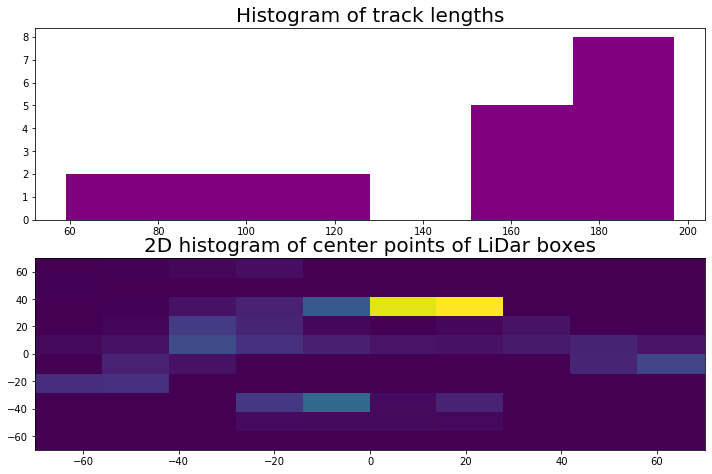

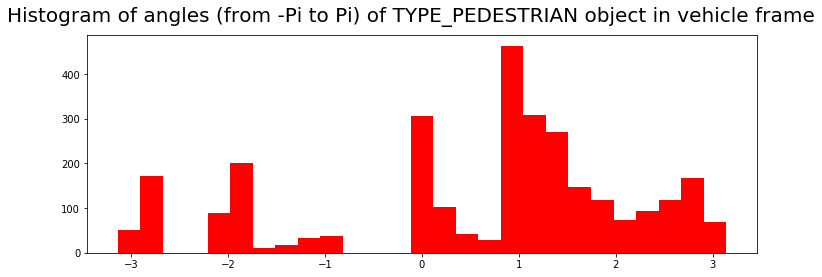

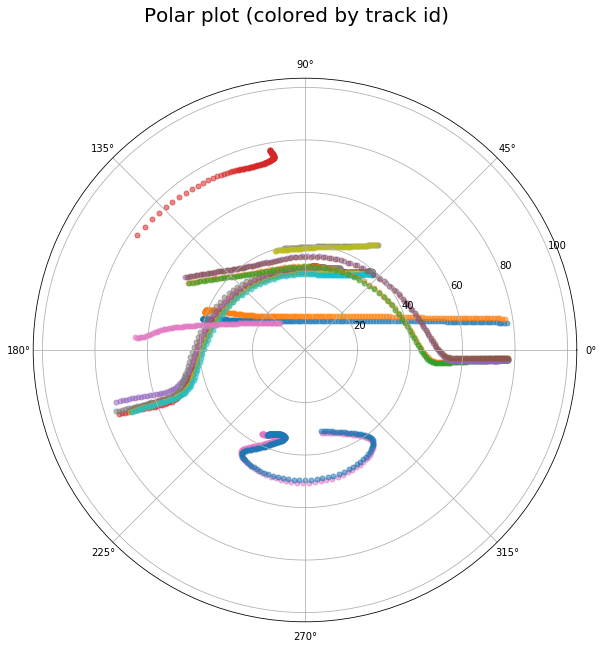

In [212]:
data_gath_first_segment.print_graphics()

In [0]:
data_gath_all = DataGatherer(validation_segments_dir, 0, len(os.listdir(validation_segments_dir)), "TYPE_PEDESTRIAN")
data_gath_all.gather_data()

In [22]:
data_gath_all.stat_df

,Number of 3D boxes,Number of unique tracks,Number of missed tracks,Number of missed frames
Statsistics for TYPE_PEDESTRIAN objects,22000,173,65,4849


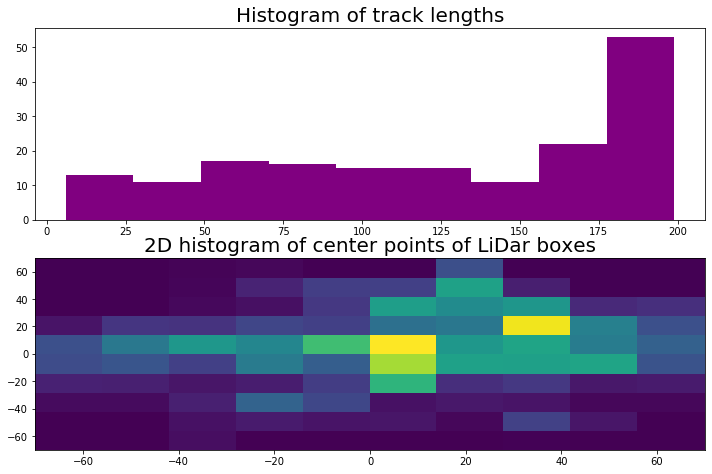

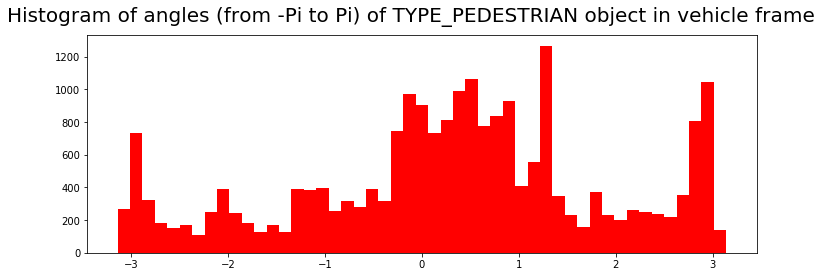

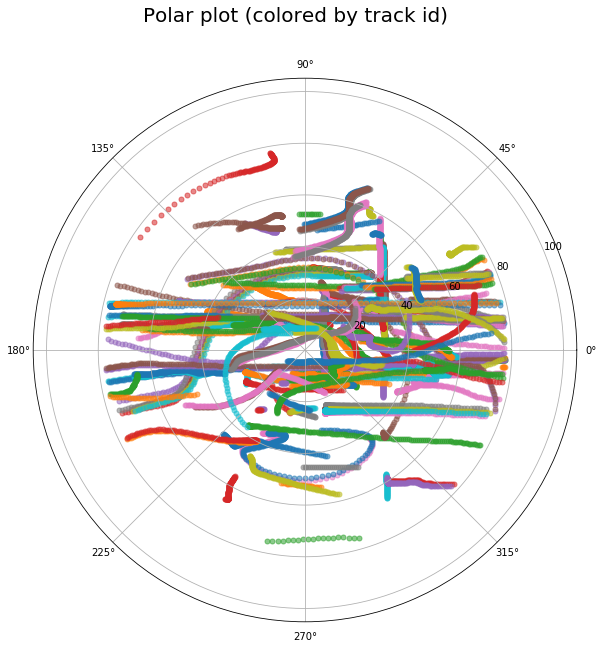

In [23]:
data_gath_all.print_graphics()

In [0]:
# install PDAL for Point Clouds filtering

In [0]:
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')
!conda install -y -q -c conda-forge python-pdal

In [0]:
!pip3 install laspy

In [0]:
import laspy

In [0]:
# testing block
segment_name = segment_names[0]
dataset = tf.data.TFRecordDataset(os.path.join(validation_segments_dir, segment_name), compression_type="")
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))

In [0]:
(range_images, camera_projections,
 range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(
    frame)

points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)

points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

In [0]:
utFile1 = File("./laspytest/data/close_points.las", mode = "w",
                header = inFile.header)
outFile1.points = points_kept
outFile1.close()